In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from function import *
import numpy as np
from sklearn.preprocessing import StandardScaler
from plotly.offline import plot
from plotly.graph_objs import *
import seaborn as sns

In [9]:
# load data
file_path = 'forestfires_with_fwi_bui.csv'
df = pd.read_csv(file_path)

# Assign the risk levels based on ISI 
isi_bins = [0, 2, 6, 12, 17, 23, 30, float('inf')]
fwi_bins = [0, 8.5, 17.2, 24.6, 38.3, 50, 64, float('inf')]
ist_risk = ['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Maximum', 'Extreme']
fwi_risk = ['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Maximum', 'Extreme']

# Create a new column for ISI risk level
df['ISI_Risk'] = pd.cut(df['ISI'], bins=isi_bins, labels=ist_risk, right=False)
df['FWI_Risk'] = pd.cut(df['FWI'], bins=fwi_bins, labels=fwi_risk, right=False)

print(df.head())

   X  Y  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area   BUI   FWI  \
0  7  5  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0  30.9  10.3   
1  7  4  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0  62.5  18.7   
2  7  4  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0  75.4  20.7   
3  8  6  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0  33.3  16.7   
4  8  6  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0  51.2  21.9   

   ISI_Risk  FWI_Risk  
0       Low       Low  
1  Moderate  Moderate  
2  Moderate  Moderate  
3  Moderate       Low  
4  Moderate  Moderate  


##### a) Visualize the data over these features in 2D/3D PC plane

In [10]:
feature_df = df[['FFMC', 'temp', 'RH', 'wind', 'BUI', 'FWI', 'area']]
# sns.pairplot(feature_df)

print(feature_df.head())

   FFMC  temp  RH  wind   BUI   FWI  area
0  86.2   8.2  51   6.7  30.9  10.3   0.0
1  90.6  18.0  33   0.9  62.5  18.7   0.0
2  90.6  14.6  33   1.3  75.4  20.7   0.0
3  91.7   8.3  97   4.0  33.3  16.7   0.0
4  89.3  11.4  99   1.8  51.2  21.9   0.0


##### (b) Choose between conventional PCA or SVD for the visualization. Make a comment whether one of the normalizations is better and why.
I think z score normalization shows more intense pattern in pca plot, because z score normalization makes all features contribute equally to variance.
and the main idea of pca is select the highest variance in higher component.

In [11]:
# Normalize the data 
def normalize_data(feature_df, method):
    """
    Normalize data with Range or Z-score, centralize data and reture x, y .
    Args: data, method
    Output: x: feature, y: target
    """
    # Normalize feature data
    x = feature_df[['FFMC', 'temp', 'RH', 'wind', 'BUI', 'FWI']]
    y = feature_df[['area']]

    for col in x.columns:
        x.loc[:, col] = method(x[col])

    # center the data
    x = x - x.mean(axis=0)
    return x, y

x_range, y_range = normalize_data(feature_df, normalization_range)
x_zscore, y_zscore = normalize_data(feature_df, normalization_zscore)

# Calculate eigenvalues and eigenvectors for the range normalized data
e_Range, v_Range = caulate_eingenvalues_eingenvectors(x_range)
print('Eigenvectors \n%s' %e_Range)
print('\nEigenvalues \n%s' %v_Range)


# Calculate eigenvalues and eigenvectors for the Z-score normalized data
e_z, v_z = caulate_eingenvalues_eingenvectors(x_zscore)
print('Eigenvectors \n%s' %e_z)
print('\nEigenvalues \n%s' %v_z)



Eigenvectors 
[0.0378131  0.0456372  0.08951581 0.00254282 0.00848125 0.00993644]

Eigenvalues 
[[ 0.07340702 -0.01951942 -0.13462835 -0.92523797 -0.31003857  0.15464925]
 [ 0.10001402 -0.31309631 -0.52503849 -0.0918926   0.70822387  0.32600182]
 [-0.27212202  0.77481468  0.21618979 -0.12607734  0.35415802  0.37087787]
 [ 0.94014346  0.233216    0.19870709 -0.0145054   0.13935388 -0.05124595]
 [-0.00387835  0.47032805 -0.66762239 -0.00234282 -0.02130328 -0.57671267]
 [ 0.16332006  0.1601678  -0.41745372  0.34551274 -0.50694556  0.63010505]]
Eigenvectors 
[1.17402856 2.78303862 1.01419909 0.56561153 0.20650231 0.25661988]

Eigenvalues 
[[ 0.03535215  0.44812136 -0.26357774 -0.77760706 -0.3020962  -0.18035907]
 [-0.27730347  0.50003314  0.05636145  0.43601578 -0.63176581  0.28399865]
 [ 0.76411934 -0.25222863  0.26964424 -0.08531623 -0.45411114  0.25748504]
 [ 0.26163424 -0.1259622  -0.8996402   0.30091915 -0.11235561 -0.05614657]
 [ 0.41588452  0.4551965   0.19470785  0.327667    0.1159

In [13]:
def pca_transform(x_norm, y, v):
    """
    PCA transformation
    Args: x_norm, y, v
    Output: pc: PCA component space, data_pca: PCA scores
    """
    # generate PCA component space (PCA scores)
    pc = np.dot(x_norm, v)
    # set data to a Pandas Dataframa to ease plotting
    names = ["PC_"+str(x+1) for x in range(pc.shape[1])]
    names.append('Area')
    data_pca = pd.DataFrame(data= np.c_[pc, y], 
                        columns=names)
    data_pca['Area'] = data_pca['Area'].astype(int)
    return pc, data_pca

# PCA transformation
pc_Range, data_pca_Range = pca_transform(x_range, y_range, v_Range)
pc_z, data_pca_z = pca_transform(x_zscore, y_zscore, v_z)

# print(data_pca_Range.head())


#### (a) visualization

/var/folders/qz/sf6z_4r52qb5z4cmlh3bn0qc0000gp/T/ipykernel_62655/2553548635.py:5: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/var/folders/qz/sf6z_4r52qb5z4cmlh3bn0qc0000gp/T/ipykernel_62655/2553548635.py:19: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



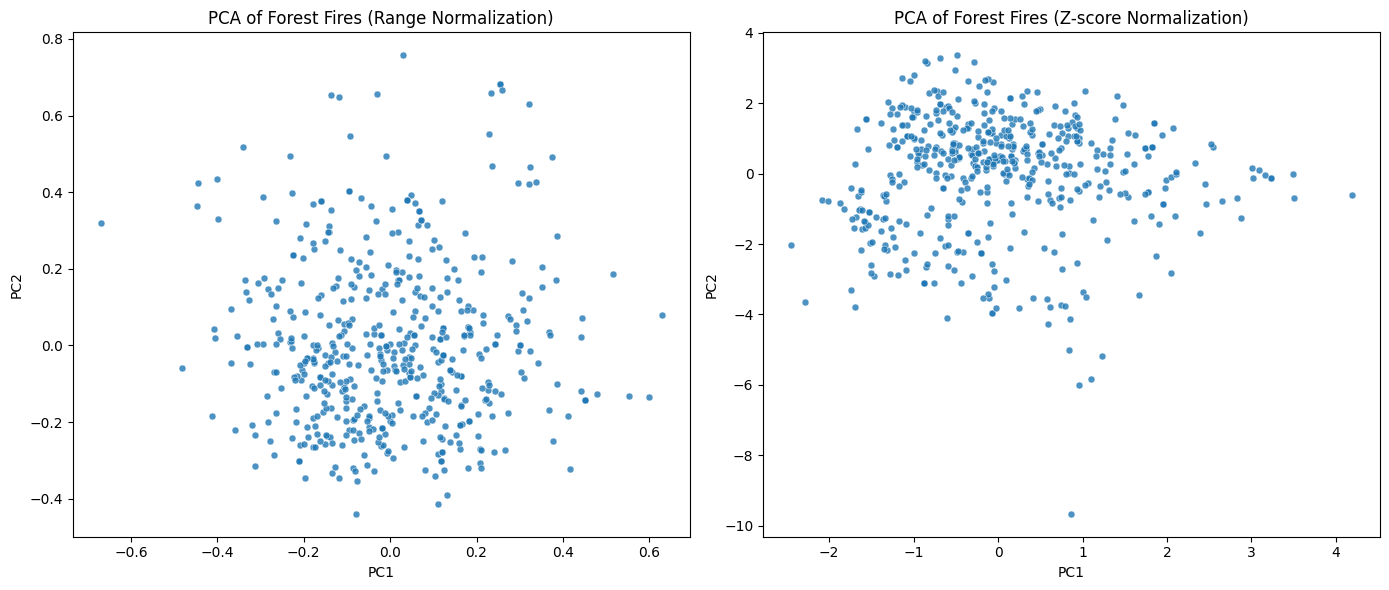

In [15]:
# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First PCA plot (Range-normalized data)
sns.scatterplot(data=data_pca_Range, 
                x='PC_1', 
                y='PC_2', 
                palette='dark:#5A9_r', 
                alpha=0.8, 
                s=25, 
                ax=axes[0])

axes[0].set_title('PCA of Forest Fires (Range Normalization)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Second PCA plot (Z-score normalized data)
# set custom color palette
sns.scatterplot(data=data_pca_z, 
                x='PC_1', 
                y='PC_2', 
                palette='dark:#5A9_r',
                alpha=0.8, 
                s=25, 
                ax=axes[1])

axes[1].set_title('PCA of Forest Fires (Z-score Normalization)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()


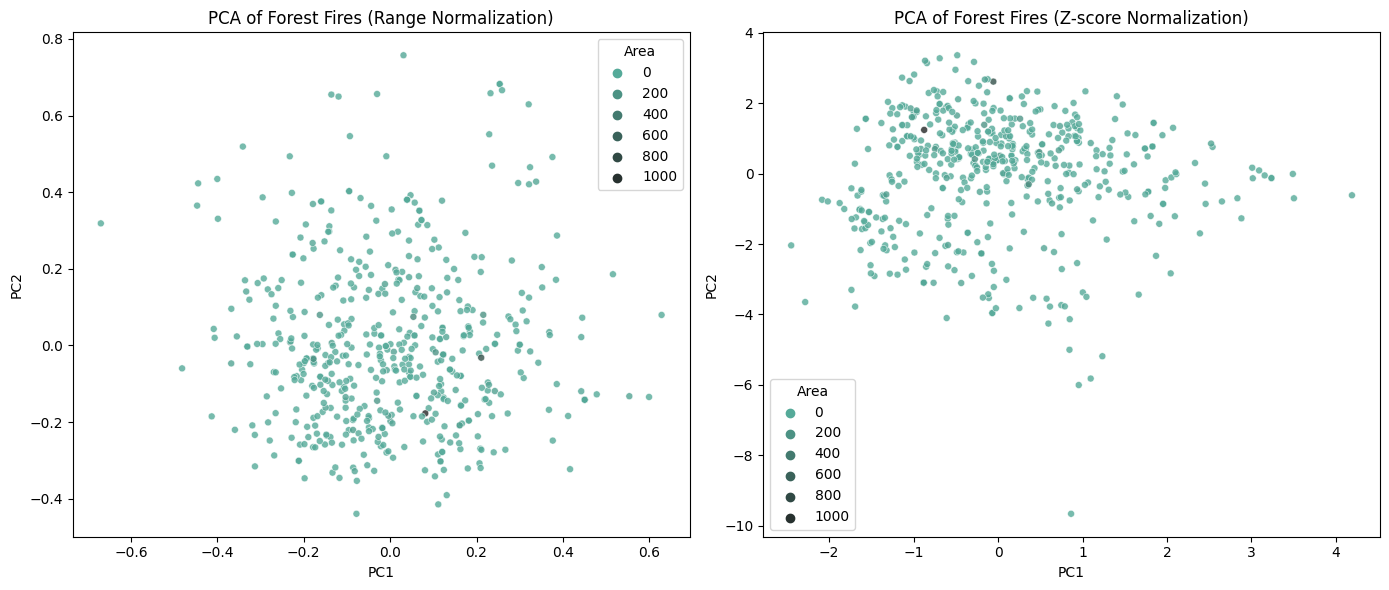

In [16]:
# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First PCA plot (Range-normalized data)
sns.scatterplot(data=data_pca_Range, 
                x='PC_1', 
                y='PC_2', 
                hue='Area',
                palette='dark:#5A9_r', 
                alpha=0.8, 
                s=25, 
                ax=axes[0])

axes[0].set_title('PCA of Forest Fires (Range Normalization)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Second PCA plot (Z-score normalized data)
# set custom color palette
sns.scatterplot(data=data_pca_z, 
                x='PC_1', 
                y='PC_2', 
                hue='Area', 
                palette='dark:#5A9_r',
                alpha=0.8, 
                s=25, 
                ax=axes[1])

axes[1].set_title('PCA of Forest Fires (Z-score Normalization)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

# print(data_pca_Range['Area'].values)
# print(data_pca_z['Area'].values)


##### c) At these visualizations, use a distinct shape/colour for data points representing a pre‐specified group of objects. Comment on the choice of your groups.

FWI_Risk is better than ISI risk

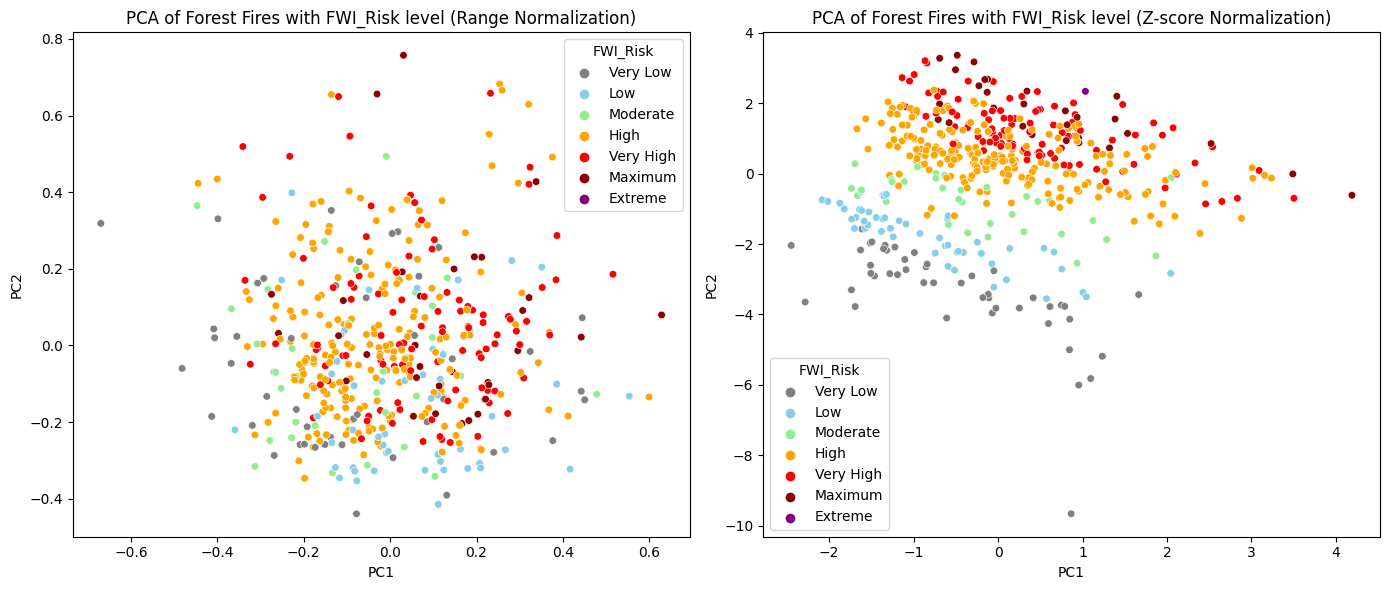

In [17]:
data_pca_Range['FWI_Risk'] = df['FWI_Risk'].values
data_pca_z['FWI_Risk'] = df['FWI_Risk'].values

custom_palette = {
    'Very Low': 'gray', 
    'Low': 'skyblue', 
    'Moderate': 'lightgreen', 
    'High': 'orange', 
    'Very High': 'red', 
    'Maximum': 'darkred', 
    'Extreme': 'purple'
}
# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First PCA plot (Range-normalized data)
sns.scatterplot(data=data_pca_Range, 
                x='PC_1', 
                y='PC_2', 
                hue='FWI_Risk',
                palette=custom_palette, 
                alpha=1, 
                s=30, 
                ax=axes[0])

axes[0].set_title('PCA of Forest Fires with FWI_Risk level (Range Normalization)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Second PCA plot (Z-score normalized data)
sns.scatterplot(data=data_pca_z, 
                x='PC_1', 
                y='PC_2', 
                hue='FWI_Risk', 
                palette=custom_palette,
                alpha=1, 
                s=30, 
                ax=axes[1])

axes[1].set_title('PCA of Forest Fires with FWI_Risk level (Z-score Normalization)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()


##### d) Calculate and make a graphical presentation of the “quality” of the PC projection of your data. Discuss your results.

In [18]:
# Range Normalization
totVar = sum(e_Range)       #Total variability of the Data
var_exp = [(i / totVar)*100 for i in sorted(e_Range, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,12)],
        y=var_exp,
        name='Exp Var',
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,12)], 
        y=cum_var_exp,
        name='Cum. Exp Var')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='Explained Variance in percentage (Range Normalization)')

fig = Figure(data=data, layout=layout)
plot(fig)

/Users/user/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/Users/user/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:572: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




'temp-plot.html'

In [19]:
# Z-score Normalization
totVar = sum(e_z)       #Total variability of the Data
var_exp = [(i / totVar)*100 for i in sorted(e_z, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,12)],
        y=var_exp,
        name='Exp Var',
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,12)], 
        y=cum_var_exp,
        name='Cum. Exp Var')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='Explained Variance in percentage (Z-score Normalization)')

fig = Figure(data=data, layout=layout)
plot(fig)

'temp-plot.html'

#### 4(b)SVD

Text(0, 0.5, 'U2')

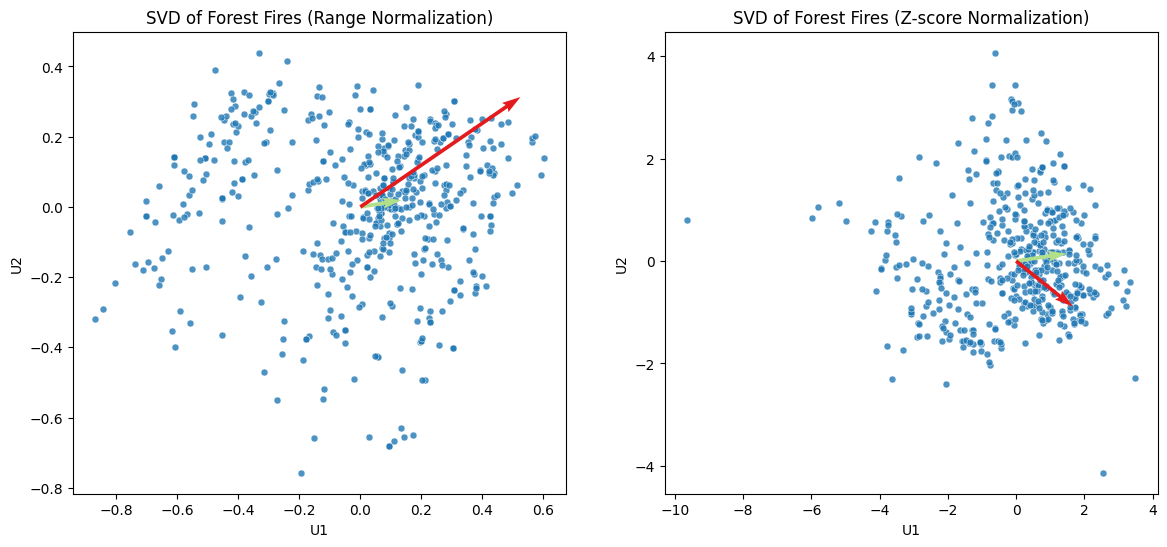

In [31]:
x = df[['FFMC', 'temp', 'RH', 'wind', 'BUI', 'FWI', 'area']]
y = df['area']
# center the data
x_range = x - x.mean(axis=0)
x_range = normalization_range(x_range)
x_zscore = x - x.mean(axis=0)
x_zscore = normalization_zscore(x_zscore)

def svd(x, y):

    u, s, vh = np.linalg.svd(x, full_matrices=True)

    ## Calculate the coordinates of the data points in the projection axes of the space spanned 
    ## by the leading eigenvectors contained in $U$ 
    u1 = u[:,0] * s[0] 
    u2 = u[:,1] * s[1] 
    # set data to a Pandas Dataframa to ease plotting
    names = ["U_"+str(i+1) for i in range(2)]
    names.append('target')
    ds_us = pd.DataFrame(data= np.c_[u1, u2, y], 
                        columns=names)
    ds_us['target'] = ds_us['target'].astype(int)
    return ds_us, u, s, vh

# SVD
ds_us1, u1, s1, vh1 = svd(x_range, y)
ds_us2, u2, s2, vh2 = svd(x_zscore, y)


# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=ds_us1, 
                x='U_1', 
                y='U_2', 
                alpha=0.8, 
                s=25, 
                ax=axes[0])

# plot the vh vector
vh1 = vh1*0.6
axes[0].quiver(0, 0, vh1[0, 0], vh1[1, 0], scale_units='xy', angles='xy', scale=0.6, color='#b2df8a', label='Loading 1')
axes[0].quiver(0, 0, vh1[0, 1], vh1[1, 1], scale_units='xy', angles='xy', scale=0.6, color='#e41a1c', label='Loading 2')
axes[0].set_title('SVD of Forest Fires (Range Normalization)')
axes[0].set_xlabel('U1')
axes[0].set_ylabel('U2')


sns.scatterplot(data=ds_us2, 
                x='U_1', 
                y='U_2', 
                alpha=0.8, 
                s=25, 
                ax=axes[1])

# plot the vh vector
vh2 = vh2*2
axes[1].quiver(0, 0, vh2[0, 0], vh2[1, 0], scale_units='xy', angles='xy', scale=0.6, color='#b2df8a', label='Loading 1')
axes[1].quiver(0, 0, vh2[0, 1], vh2[1, 1], scale_units='xy', angles='xy', scale=0.6, color='#e41a1c', label='Loading 2')
axes[1].set_title('SVD of Forest Fires (Z-score Normalization)')
axes[1].set_xlabel('U1')
axes[1].set_ylabel('U2')